In [30]:
##mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import json
import os
import pandas as pd
import torch
import time
import sys
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn.init as init
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import warnings

In [0]:
base_path = '/content/drive/My Drive/DL_exp/'

## Required Functions

In [0]:
def shell_k_fold_data(num_samples,points_dim,center,kfold,radius_of_shell,thickness_of_shell,label_of_shell,seed=1234):
  # generate points on circle of unit radius 
  np.random.seed(seed)
  a = np.random.uniform(-1.0, 1.0, (num_samples,points_dim))
  norm = np.sqrt(np.sum(np.square(a),axis=1))
  unit_circle = a/norm[:,None]
  data = np.zeros((num_samples,points_dim+1))
  
  for i in range(num_samples):
    if i%(2*kfold)==0:
      data[i,:-1] = (radius_of_shell[0]*unit_circle[i,:])+[center,center]
      data[i,-1] =  label_of_shell[0]
    if i%(2*kfold)==1:
      data[i,:-1] = (radius_of_shell[1]*unit_circle[i,:])+[center,center]
      data[i,-1] =  label_of_shell[1]
    if i%(2*kfold)==2:
      data[i,:-1] = (radius_of_shell[0]*unit_circle[i,:])+[-center,center]
      data[i,-1] =  label_of_shell[0]
    if i%(2*kfold)==3:
      data[i,:-1] = (radius_of_shell[1]*unit_circle[i,:])+[-center,center]
      data[i,-1] =  label_of_shell[1]
    if i%(2*kfold)==4:
      data[i,:-1] = (radius_of_shell[0]*unit_circle[i,:])+[-center,-center]
      data[i,-1] =  label_of_shell[0]
    if i%(2*kfold)==5:
      data[i,:-1] = (radius_of_shell[1]*unit_circle[i,:])+[-center,-center]
      data[i,-1] =  label_of_shell[1]
    if i%(2*kfold)==6:
      data[i,:-1] = (radius_of_shell[0]*unit_circle[i,:])+[center,-center]
      data[i,-1] =  label_of_shell[0]
    if i%(2*kfold)==7:
      data[i,:-1] = (radius_of_shell[1]*unit_circle[i,:])+[center,-center]
      data[i,-1] =  label_of_shell[1]

  np.random.shuffle(data)
  return data

In [0]:
### custom dataset class for dataset. read the csv in __init__ . 
# input : csv file path
# output: returns (data,label)
class load_dataset(Dataset):
    def __init__(self, data):
      if type(data)==str:
        self.samples = pd.read_csv(data).values
      else:
        self.samples = data

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx,:-1] ,self.samples[idx,-1]
      
### Multilayer Perceptron Model
# input : number of features (input), hidden nodes list , number of classes
class MultilayerPerceptron(torch.nn.Module):
  
    def __init__(self,num_features,hidden_nodes_list,num_classes):
        super(MultilayerPerceptron, self).__init__()
        
        num_hidden_layes = len(hidden_nodes_list)
        self.hidden = torch.nn.ModuleList()
        
        self.hidden.append(torch.nn.Linear(num_features, hidden_nodes_list[0]))
        for k in range(num_hidden_layes-1):
            self.hidden.append(torch.nn.Linear(hidden_nodes_list[k], hidden_nodes_list[k+1]))    
        self.hidden.append(torch.nn.Linear(hidden_nodes_list[num_hidden_layes-1], num_classes))
        
    # input : features
    # output: logits , probabilities
    def forward(self, x):
        out = x
        for layer in self.hidden[:-1]:
          out = layer(out)
          out = F.relu(out)

        logits = self.hidden[-1](out)
        probas = F.log_softmax(logits, dim=1)
        return logits, probas
    
### function to compute the accuracy
# input : model, data of type DataLoader
# output: cost (log loss), accuracy 
def compute_accuracy(net, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.eval()
    cost, correct_pred, num_examples = 0, 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.float().to(device)
            targets = targets.long().to(device)
            logits, probas = net(features)
            cost += F.cross_entropy(logits, targets) * targets.size(0)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return cost/num_examples , correct_pred.float()/num_examples * 100

In [0]:
## Training Function
def train_model(num_features, hidden_nodes_list, num_classes, random_seed, learning_rate, train_dataloader):

  ### weight initialization function
  # use : model.apply(init_weights)
  def init_weights(m):
    if isinstance(m, torch.nn.Linear):
      if initialisation_method=='xavier':
        init.xavier_uniform_(m.weight)
      if initialisation_method=='he':
        init.kaiming_uniform_(m.weight)
      m.bias.data.fill_(0.01)

  initialisation_method = 'xavier'
  optimisation_method = 'sgdwm'  

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     
  torch.manual_seed(random_seed)
  model = MultilayerPerceptron(num_features,hidden_nodes_list,num_classes)
  model.apply(init_weights)
  model = model.to(device)

  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

  epoch = 0
  with torch.set_grad_enabled(False):
    cost,best_acc = compute_accuracy(model, train_dataloader)

  count = 1
  prev_acc=best_acc
  best_epoch = epoch
  best_cost = cost

  while True:
    model.train()
    for batch_idx, (features, targets) in enumerate(train_dataloader):

        features = features.float().to(device)
        targets = targets.long().to(device)
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()
        optimizer.step()

    with torch.set_grad_enabled(False):
        cost,acc = compute_accuracy(model, train_dataloader)
        
    epoch+=1

    # Stopping conditions
    if prev_acc==acc:
      count+=1
    else:
      prev_acc=acc
      count=1
    if (epoch>50 and best_acc-acc>=5) or count==10 or epoch==400:
    # if (epoch>50 and best_acc-acc>=5) or epoch==400:
      break
    if acc>best_acc:
      best_acc=acc
      best_epoch = epoch
      best_cost = cost
      
  return model

##  Depth-Width Analysis

In [0]:
with open(base_path+'result/shellFold_acc.json', mode='r') as readjson:
  result_list = json.loads(readjson.read())

radius1 = [0.1,0.2,0.3,0.4]
radius2 = [0.5,0.6,0.7,0.8]

for r1 in radius1:
  for r2 in radius2:
    radius_of_shell=[r1,r2]
    thickness_of_shell = [0,0]
    label_of_shell = [0,1]
    num_samples = 800
    dim = 2
    center = 1
    kfold = 4

    train_data = shell_k_fold_data(num_samples,dim,center,kfold,radius_of_shell,thickness_of_shell,label_of_shell)
    train_dataset = load_dataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)

    num_samples = 200         
    test_data = shell_k_fold_data(num_samples,dim,center,kfold,radius_of_shell,thickness_of_shell,label_of_shell,10)
    test_dataset = load_dataset(test_data)
    test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

    # Training
    h_nodes = [6,12,24,48,72,96,144,192]
    num_features  = dim        
    num_classes   = 2                                      
    random_seed = 1000
    learning_rate = 0.05

    for h in h_nodes:
      for l in [1,2,3]:
        if l==1:
          hidden_nodes  = [h]
        if l==2:
          hidden_nodes  = [math.ceil(h*0.6),math.floor(h*0.4)]
        if l==3:
          hidden_nodes  = [math.ceil(h*0.5),math.ceil(h*0.3),math.floor(h*0.2)] 
        model = train_model(num_features, hidden_nodes, num_classes, random_seed, learning_rate, train_dataloader)
        cost,train_acc = compute_accuracy(model, train_dataloader)
        cost,test_acc = compute_accuracy(model, test_dataloader)

        dict = {'radius1':r1,'radius2':r2,'kfold':kfold,'h_nodes':h,'layer':l,'train_acc':train_acc.data.tolist(),'test_acc':test_acc.data.tolist(),'random_seed':random_seed}
        result_list.append(dict)

with open(base_path+'result/shellFold_acc.json', mode='w') as feedjson:
  json.dump(result_list,feedjson)

(0, 110)

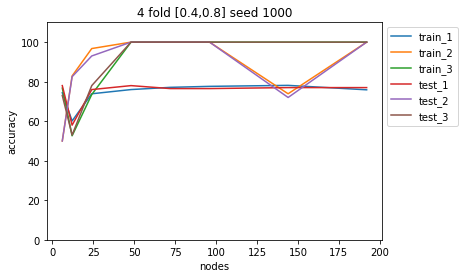

In [55]:
with open(base_path+'result/shellFold_acc.json', mode='r') as readjson:
  result_list = json.loads(readjson.read())
len(result_list)

r1 =0.4
r2=0.8
l=3
seed = 1000
kfold = 4
nodes = [f['h_nodes'] for f in result_list if f['radius1']==r1 and f['radius2']==r2 and f['layer']==1 and f['random_seed']==seed and f['kfold']==kfold]
train_acc_1 = [f['train_acc'] for f in result_list if f['radius1']==r1 and f['radius2']==r2 and f['layer']==1 and f['random_seed']==seed and f['kfold']==kfold]
test_acc_1 = [f['test_acc'] for f in result_list if f['radius1']==r1 and f['radius2']==r2 and f['layer']==1 and f['random_seed']==seed and f['kfold']==kfold]
train_acc_2 = [f['train_acc'] for f in result_list if f['radius1']==r1 and f['radius2']==r2 and f['layer']==2 and f['random_seed']==seed and f['kfold']==kfold]
test_acc_2 = [f['test_acc'] for f in result_list if f['radius1']==r1 and f['radius2']==r2 and f['layer']==2 and f['random_seed']==seed and f['kfold']==kfold]
train_acc_3 = [f['train_acc'] for f in result_list if f['radius1']==r1 and f['radius2']==r2 and f['layer']==3 and f['random_seed']==seed and f['kfold']==kfold]
test_acc_3 = [f['test_acc'] for f in result_list if f['radius1']==r1 and f['radius2']==r2 and f['layer']==3 and f['random_seed']==seed and f['kfold']==kfold]
fig = plt.figure()
plt.plot(nodes,train_acc_1,label='train_1')
plt.plot(nodes,train_acc_2,label='train_2')
plt.plot(nodes,train_acc_3,label='train_3')
# plt.legend(bbox_to_anchor=(1, 1))
# plt.xlabel('nodes')
# plt.ylabel('accuracy')
# axes = plt.gca()
# axes.set_ylim([0,110])

# fig = plt.figure()
plt.plot(nodes,test_acc_1,label='test_1')
plt.plot(nodes,test_acc_2,label='test_2')
plt.plot(nodes,test_acc_3,label='test_3')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('nodes')
plt.ylabel('accuracy')
plt.title('4 fold [0.4,0.8] seed '+str(seed))
axes = plt.gca()
axes.set_ylim([0,110])

## Transfer Learning

In [0]:
### SOURCE DOMAIN
# Data
radius_of_shell=[0.4,0.7]
thickness_of_shell = [0,0]
label_of_shell = [0,1]
num_samples = 800
dim = 2
center = 1
kfold = 4

source_train_data = shell_k_fold_data(num_samples,dim,center,kfold,radius_of_shell,thickness_of_shell,label_of_shell)
source_train_dataset = load_dataset(source_train_data)
source_train_dataloader = DataLoader(source_train_dataset, batch_size=len(source_train_dataset), shuffle=True)

num_samples = 200         
source_test_data = shell_k_fold_data(num_samples,dim,center,kfold,radius_of_shell,thickness_of_shell,label_of_shell,10)
source_test_dataset = load_dataset(source_test_data)
source_test_dataloader = DataLoader(source_test_dataset, batch_size=len(source_test_dataset), shuffle=True)

# Training
h_nodes = 48
num_features  = dim        
hidden_nodes_list_1layer  = [h_nodes]
hidden_nodes_list_2layer  = [math.ceil(h_nodes*0.6),math.floor(h_nodes*0.4)]
hidden_nodes_list_3layer  = [math.ceil(h_nodes*0.5),math.ceil(h_nodes*0.3),math.floor(h_nodes*0.2)]
num_classes   = 2                                      
random_seed = 1000
learning_rate = 0.05

source_model = []
source_model_1layer = train_model(num_features, hidden_nodes_list_1layer, num_classes, random_seed, learning_rate, source_train_dataloader)
source_model.append(source_model_1layer)
source_model_2layer = train_model(num_features, hidden_nodes_list_2layer, num_classes, random_seed, learning_rate, source_train_dataloader)
source_model.append(source_model_2layer)
source_model_3layer = train_model(num_features, hidden_nodes_list_3layer, num_classes, random_seed, learning_rate, source_train_dataloader)
source_model.append(source_model_3layer)

cost,source_trained_1layer = compute_accuracy(source_model_1layer, source_train_dataloader)
cost,source_test_1layer = compute_accuracy(source_model_1layer, source_test_dataloader)
print(source_trained_1layer,source_test_1layer)

cost,source_trained_2layer = compute_accuracy(source_model_2layer, source_train_dataloader)
cost,source_test_2layer = compute_accuracy(source_model_2layer, source_test_dataloader)
print(source_trained_2layer,source_test_2layer)

cost,source_trained_3layer = compute_accuracy(source_model_3layer, source_train_dataloader)
cost,source_test_3layer = compute_accuracy(source_model_3layer, source_test_dataloader)
print(source_trained_3layer,source_test_3layer)

tensor(62.5000, device='cuda:0') tensor(55.5000, device='cuda:0')
tensor(99.6250, device='cuda:0') tensor(98.5000, device='cuda:0')
tensor(99.8750, device='cuda:0') tensor(99.0000, device='cuda:0')


In [0]:
## TARGET DOMAIN
radius = [0.5,0.6,0.7,0.8]
target_trained = np.zeros((len(radius),3))
target_test = np.zeros((len(radius),3))
svc_fl_test = np.zeros((len(radius),3))
svc_sl_test = np.zeros((len(radius),3))
svc_tl_test = np.zeros((len(radius),3))
svc_fl_trained = np.zeros((len(radius),3))
svc_sl_trained = np.zeros((len(radius),3))
svc_tl_trained = np.zeros((len(radius),3))

for i in range(len(radius)):
  # Data
  radius_of_shell=[0.4,radius[i]]
  thickness_of_shell = [0,0]
  label_of_shell = [0,1]
  dim=2
  num_samples = 200
  center = 1
  kfold = 4

  target_train_data = shell_k_fold_data(num_samples,dim,center,kfold,radius_of_shell,thickness_of_shell,label_of_shell)
  target_train_dataset = load_dataset(target_train_data)
  target_train_dataloader = DataLoader(target_train_dataset, batch_size=len(target_train_dataset), shuffle=True)

  target_test_data = shell_k_fold_data(num_samples,dim,center,kfold,radius_of_shell,thickness_of_shell,label_of_shell,10)
  target_test_dataset = load_dataset(target_test_data)
  target_test_dataloader = DataLoader(target_test_dataset, batch_size=len(target_test_dataset), shuffle=True)

  X_train = target_train_data[:,:-1]
  y_train = target_train_data[:,-1]
  X_test = target_test_data[:,:-1]
  y_test = target_test_data[:,-1]

  # Training
  h_nodes = 24
  num_features  = dim        
  hidden_nodes_list_1layer  = [h_nodes]
  hidden_nodes_list_2layer  = [math.ceil(h_nodes*0.6),math.floor(h_nodes*0.4)]
  hidden_nodes_list_3layer  = [math.ceil(h_nodes*0.5),math.ceil(h_nodes*0.3),math.floor(h_nodes*0.2)]
  hidden_nodes_list = [hidden_nodes_list_1layer, hidden_nodes_list_2layer, hidden_nodes_list_3layer]
  num_classes   = 2                                      
  random_seed = 1000
  learning_rate = 0.05

  for layer in range(3):
    target_model = train_model(num_features, hidden_nodes_list[layer], num_classes, random_seed, learning_rate, target_train_dataloader)

    cost,acc = compute_accuracy(target_model, target_train_dataloader)
    target_trained[i][layer] = acc.data.tolist()
    cost,acc = compute_accuracy(target_model, target_test_dataloader)
    target_test[i][layer] = acc.data.tolist()

    # Transfer Learning
    copy_model_dict = source_model[layer].state_dict()
    fl_weight = copy_model_dict['hidden.0.weight'].cpu().numpy()
    fl_bias = copy_model_dict['hidden.0.bias'].cpu().numpy()
    if layer==1 or layer==2:
      sl_weight = copy_model_dict['hidden.1.weight'].cpu().numpy()
      sl_bias = copy_model_dict['hidden.1.bias'].cpu().numpy()
    if layer==2:
      tl_weight = copy_model_dict['hidden.2.weight'].cpu().numpy()
      tl_bias = copy_model_dict['hidden.2.bias'].cpu().numpy()

    X_train_fl = np.dot(X_train,np.transpose(fl_weight))+fl_bias
    if layer==1 or layer==2:
      X_train_afl = np.maximum(0,X_train_fl)
      X_train_sl = np.dot(X_train_afl,np.transpose(sl_weight))+sl_bias
    if layer==2:
      X_train_asl = np.maximum(0,X_train_sl)
      X_train_tl = np.dot(X_train_asl,np.transpose(tl_weight))+tl_bias

    X_test_fl = np.dot(X_test,np.transpose(fl_weight))+fl_bias
    if layer==1 or layer==2:
      X_test_afl = np.maximum(0,X_test_fl)
      X_test_sl = np.dot(X_test_afl,np.transpose(sl_weight))+sl_bias
    if layer==2:
      X_test_asl = np.maximum(0,X_test_sl)
      X_test_tl = np.dot(X_test_asl,np.transpose(tl_weight))+tl_bias

    # First layer Features
    svm = LinearSVC(C=1,random_state=0, tol=1e-5,max_iter=2000)
    svm.fit(X_train_fl, y_train)

    y_svm = svm.predict(X_train_fl)
    svc_fl_trained[i][layer] = metrics.accuracy_score(y_train, y_svm)*100
    y_svm = svm.predict(X_test_fl)
    svc_fl_test[i][layer] = metrics.accuracy_score(y_test, y_svm)*100

    # Second Layer Features
    if layer==1 or layer==2:
      svm = LinearSVC(C=1,random_state=0, tol=1e-5,max_iter=2000)
      svm.fit(X_train_sl, y_train)

      y_svm = svm.predict(X_train_sl)
      svc_sl_trained[i][layer] = metrics.accuracy_score(y_train, y_svm)*100
      y_svm = svm.predict(X_test_sl)
      svc_sl_test[i][layer] = metrics.accuracy_score(y_test, y_svm)*100

    # # Third Layer Features
    if layer==2:
      svm = LinearSVC(C=1,random_state=0, tol=1e-5,max_iter=2000)
      svm.fit(X_train_tl, y_train)

      y_svm = svm.predict(X_train_tl)
      svc_tl_trained[i][layer] = metrics.accuracy_score(y_train, y_svm)*100
      y_svm = svm.predict(X_test_tl)
      svc_tl_test[i][layer] = metrics.accuracy_score(y_test, y_svm)*100

# print(target_trained)
# print(svc_fl_trained)
# print(svc_sl_trained)
# print(svc_tl_trained)
# print(target_test)
# print(svc_fl_test)
# print(svc_sl_test)
# print(svc_tl_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(1, 110)

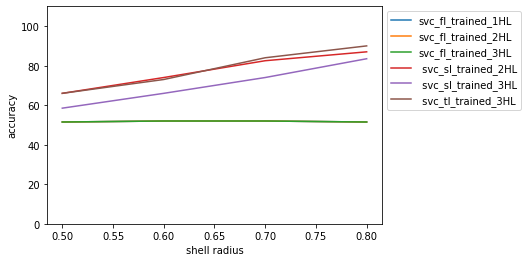

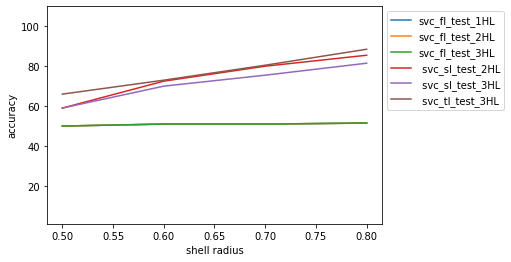

In [0]:
fig = plt.figure()
# plt.plot(radius,target_trained[:,0],label='target_trained_1HL')
# plt.plot(radius,target_trained[:,1],label='target_trained_2HL')
# plt.plot(radius,target_trained[:,2],label='target_trained_3HL')
plt.plot(radius,svc_fl_trained[:,0],label='svc_fl_trained_1HL')
plt.plot(radius,svc_fl_trained[:,1],label='svc_fl_trained_2HL')
plt.plot(radius,svc_fl_trained[:,2],label='svc_fl_trained_3HL')
plt.plot(radius,svc_sl_trained[:,1],label=' svc_sl_trained_2HL')
plt.plot(radius,svc_sl_trained[:,2],label=' svc_sl_trained_3HL')
plt.plot(radius,svc_tl_trained[:,2],label=' svc_tl_trained_3HL')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('shell radius')
plt.ylabel('accuracy')
axes = plt.gca()
axes.set_ylim([0,110])
# fig.suptitle('(1,1.6)-(1,r,2) 128 dim', fontsize=14)
# fig.savefig(base_path+'result/1_1.6_1_r_2.jpg')

fig = plt.figure()
# plt.plot(radius,target_test[:,0],label='target_test_1HL')
# plt.plot(radius,target_test[:,1],label='target_test_2HL')
# plt.plot(radius,target_test[:,2],label='target_test_3HL')
plt.plot(radius,svc_fl_test[:,0],label='svc_fl_test_1HL')
plt.plot(radius,svc_fl_test[:,1],label='svc_fl_test_2HL')
plt.plot(radius,svc_fl_test[:,2],label='svc_fl_test_3HL')
plt.plot(radius,svc_sl_test[:,1],label=' svc_sl_test_2HL')
plt.plot(radius,svc_sl_test[:,2],label=' svc_sl_test_3HL')
plt.plot(radius,svc_tl_test[:,2],label=' svc_tl_test_3HL')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('shell radius')
plt.ylabel('accuracy')
axes = plt.gca()
axes.set_ylim([1,110])
# fig.suptitle('(1,1.6)-(1,r,2) 128 dim', fontsize=14)
# fig.savefig(base_path+'result/1_1.6_1_r_2.jpg')